# Modelling

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [21]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Data preparation:

Pipeline:

In [22]:
class FeaturesProcessor(BaseEstimator, TransformerMixin):
    """Imputes age data and creates new features: Deck and Family"""
    def __init__(self, features):
        self.features = features
        self.age = 'Age' in features
        self.deck = 'Deck' in features
        self.family = 'Family' in features
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.age:
            X['Age'] = X['Age'].fillna(train.groupby(['Pclass','Sex'])['Age'].transform('median'))
        if self.deck:
            X['Deck'] = X['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'Mis')
            X = X.drop('Cabin',axis=1)
        if self.family:
            X['Family'] = X['SibSp'] + X['Parch']
            X = X.drop(['SibSp', 'Parch'], axis=1)
        return X

In [23]:
# Starting pipeline:
# - imputing Age data
# - adding features Deck and Family
preprocess_pipeline_1 = Pipeline([
        ("features_processor", FeaturesProcessor(features=['Age','Deck','Family']))
    ])


# Pipeline for numerical attributes:
# - imputation of eventual raemaining missings (they might occur in the test set)
# - scaling the data
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy='median')), 
        ("scaler", StandardScaler())
    ])


# Pipeline for categorical attributes:
# - imputation of eventual raemaining missings (they might occur in the test set)
# - creating dummy variables 
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ("cat_encoder", OneHotEncoder(sparse=False))
    ])

num_cols = ["Age", "Fare", "Family"]
cat_cols = ["Pclass", "Sex", "Embarked", "Deck"]

preprocess_pipeline_2 = ColumnTransformer([
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols),
    ]) 


Train and test sets:

In [24]:
X_train = preprocess_pipeline_1.fit_transform(train)
X_train = preprocess_pipeline_2.fit_transform(X_train[num_cols + cat_cols])
y_train = train['Survived']

In [25]:
X_test = preprocess_pipeline_1.fit_transform(test)
X_test = preprocess_pipeline_2.fit_transform(X_test[num_cols + cat_cols])

Logistic regression:

In [30]:
lreg = LogisticRegression(max_iter=1000, random_state=42).fit(X_train, y_train)

lreg_scores = cross_val_score(lreg, X_train, y_train, cv=10)
lreg_scores.mean()

0.8103370786516855

Random forest:

In [31]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8103995006242197

Support vector machine:

In [32]:
svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8148189762796505

SVM had the highest mean accuracy

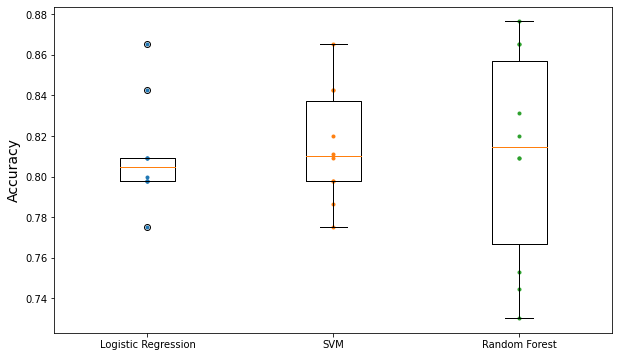

In [33]:
plt.figure(figsize=(10, 6))
plt.plot([1]*10, lreg_scores, ".")
plt.plot([2]*10, svm_scores, ".")
plt.plot([3]*10, forest_scores, ".")
plt.boxplot([lreg_scores, svm_scores, forest_scores], labels=("Logistic Regression","SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()


Random Forest did reach higher maximum accuracy than SVM but it's worst results were worse than the ones of SVM's (RF has wider spread).<br>
Concluding, SVM had higher mean and more reasonable spread => let's perform GridSearch on this method.


TODO: 
- gridsearch
- different variables variants 